# Eda of data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train= pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
Val= pd.read_csv('val.csv')

In [31]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Val shape:", Val.shape)
print("\nTrain Info:")
print(train.info())

print("\nMissing values:")
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

Train shape: (1914056, 46)
Test shape: (546874, 45)
Val shape: (273437, 46)

Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914056 entries, 0 to 1914055
Data columns (total 46 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Unique ID                        int64  
 1   Rider_ID                         int64  
 2   category_x                       object 
 3   Circuit_Length_km                float64
 4   Laps                             int64  
 5   Grid_Position                    int64  
 6   Avg_Speed_kmh                    float64
 7   Track_Condition                  object 
 8   Humidity_%                       int64  
 9   Tire_Compound_Front              object 
 10  Tire_Compound_Rear               object 
 11  Penalty                          object 
 12  Championship_Points              int64  
 13  Championship_Position            int64  
 14  Session                          object 
 15  year_x     

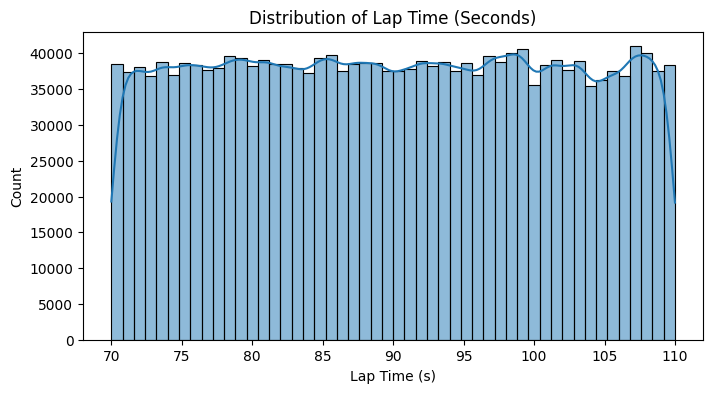

In [9]:
plt.figure(figsize=(8, 4))
sns.histplot(train['Lap_Time_Seconds'], bins=50, kde=True)
plt.title("Distribution of Lap Time (Seconds)")
plt.xlabel("Lap Time (s)")
plt.show()

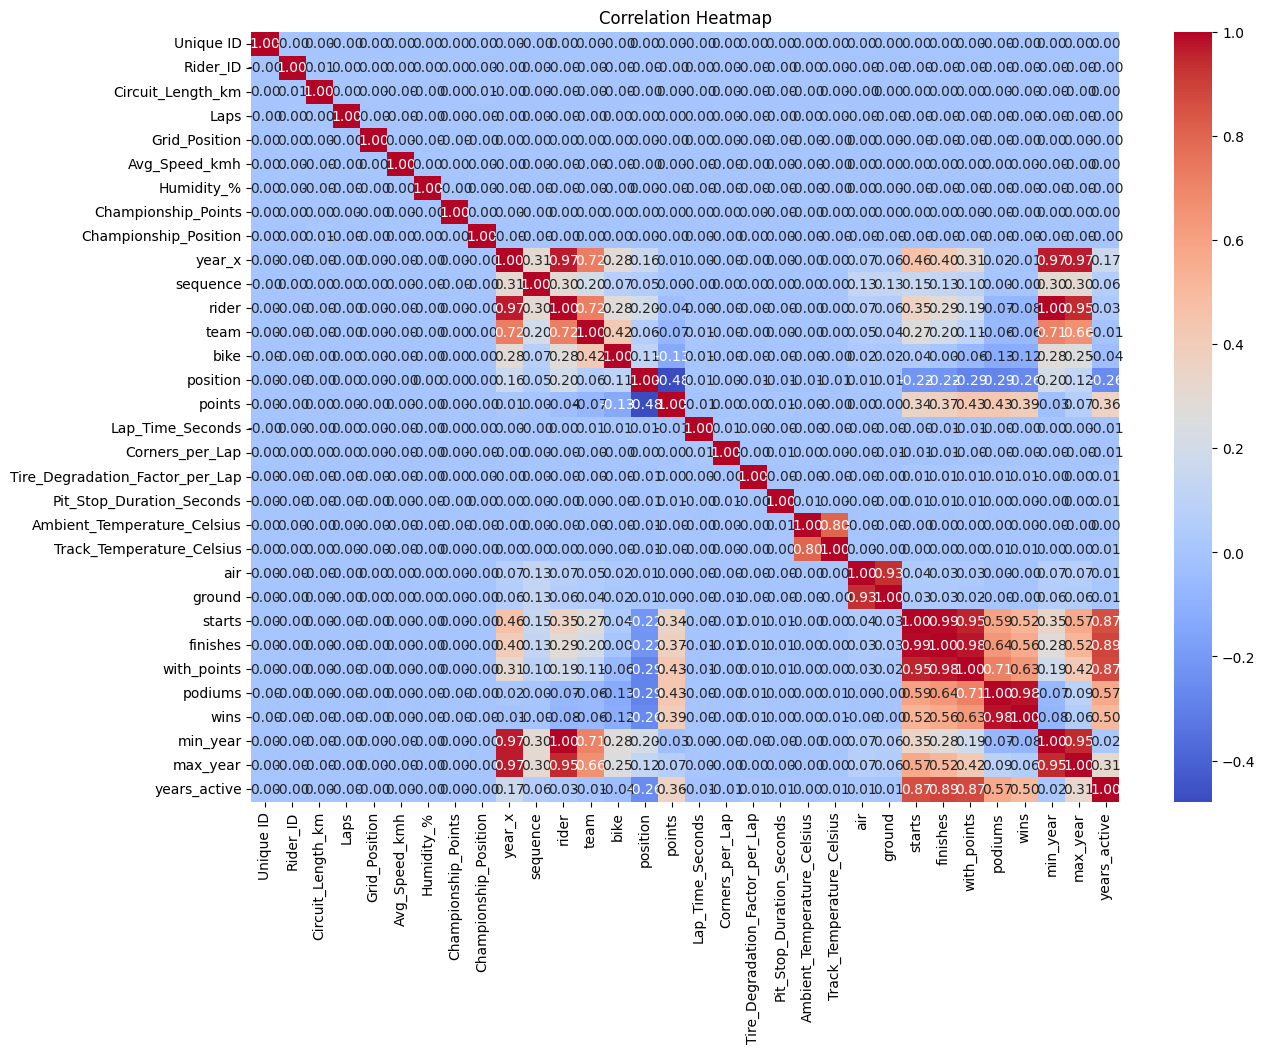

In [10]:
numeric_cols = train.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

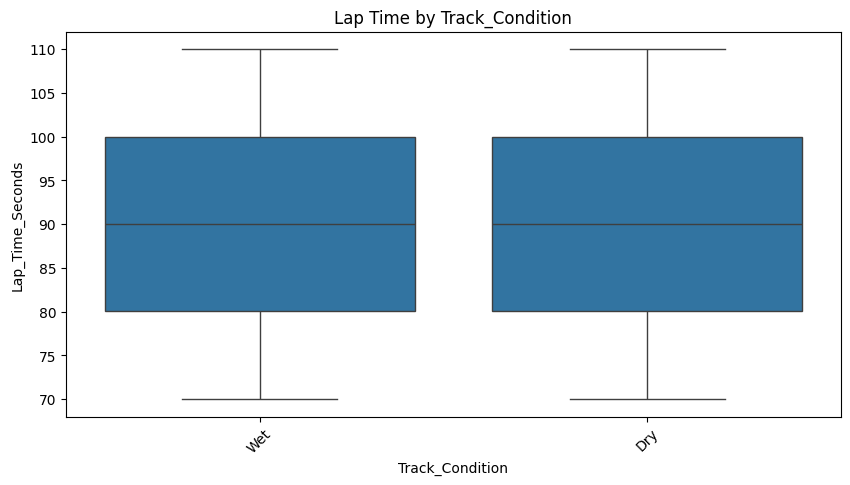

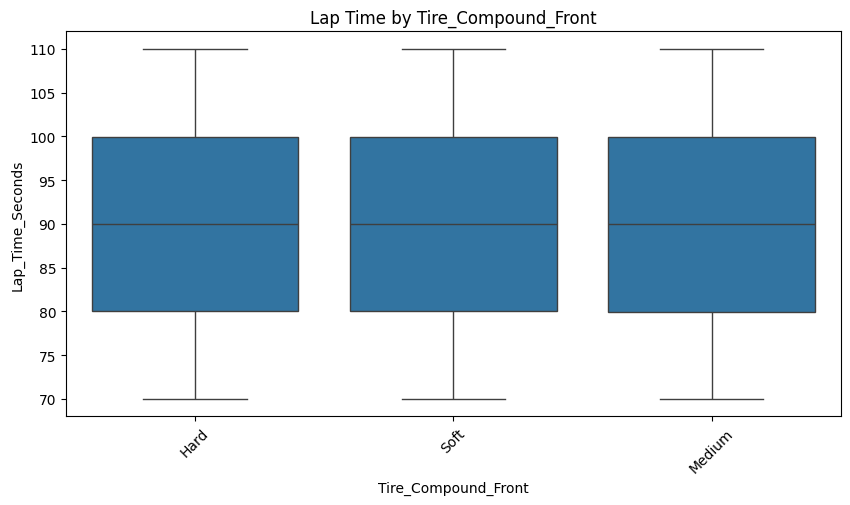

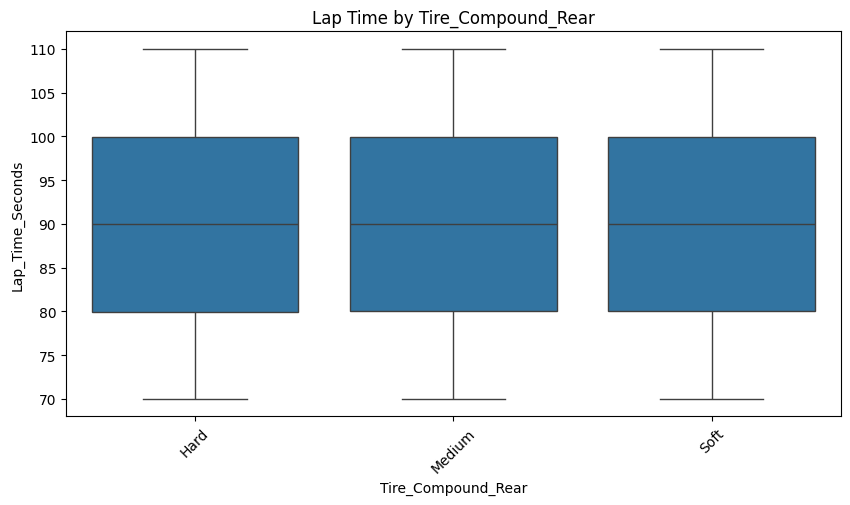

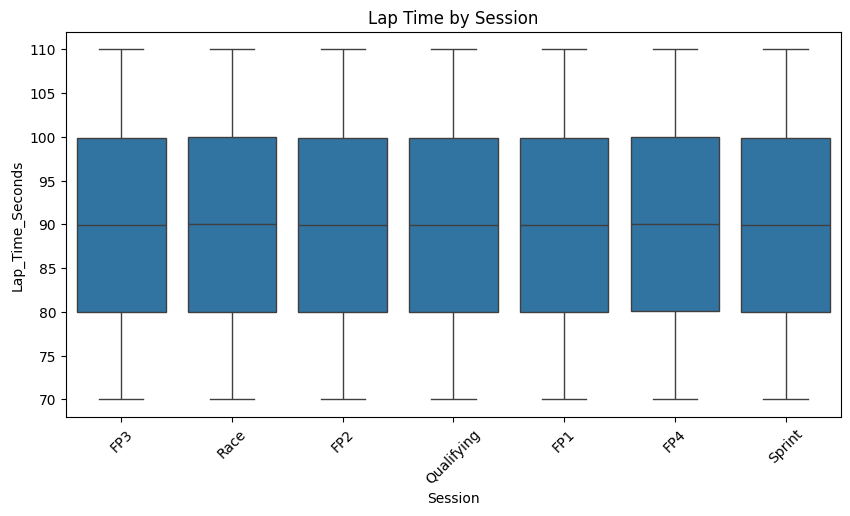

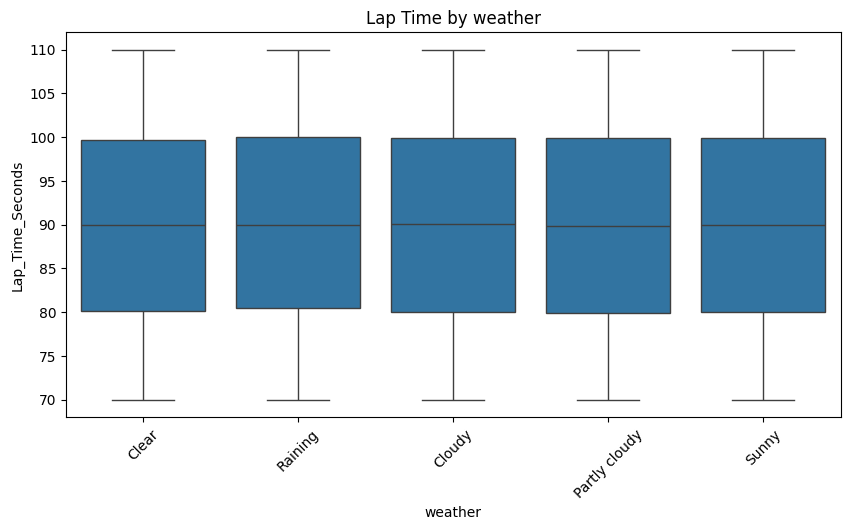

In [12]:
categorical_features = ['Track_Condition', 'Tire_Compound_Front', 'Tire_Compound_Rear', 'Session', 'weather']
for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=train, x=col, y='Lap_Time_Seconds')
    plt.title(f"Lap Time by {col}")
    plt.xticks(rotation=45)
    plt.show()

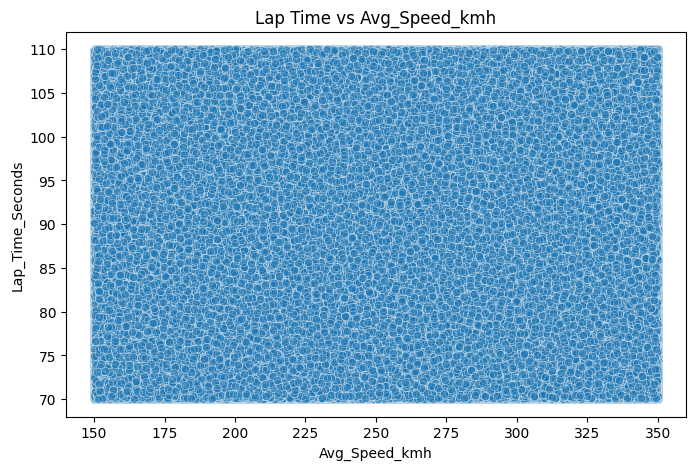

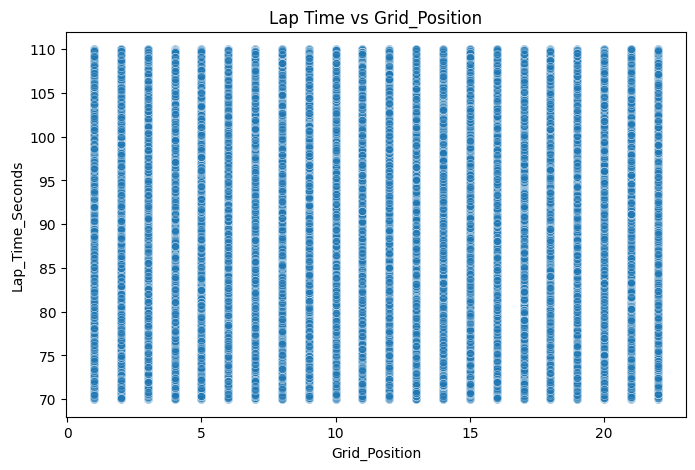

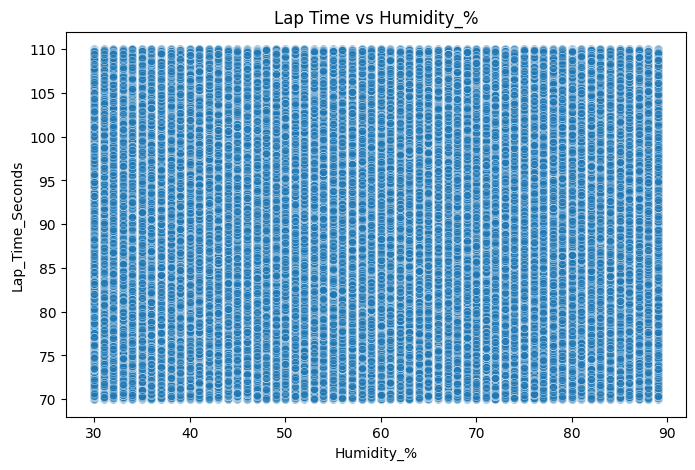

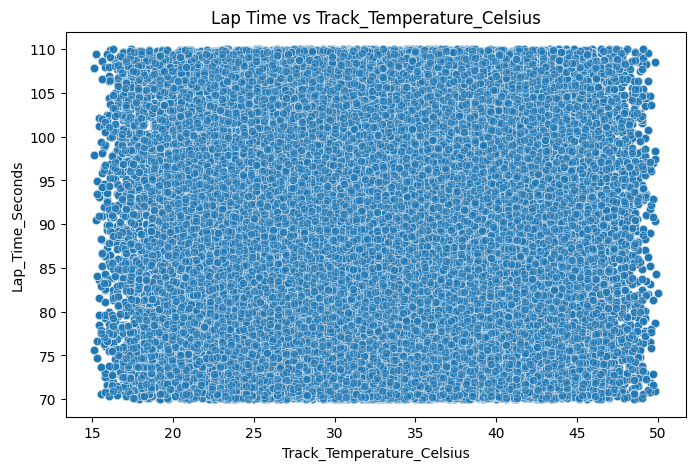

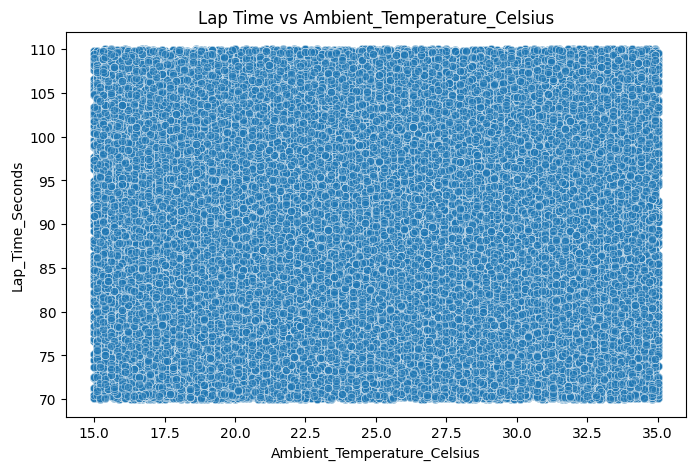

In [13]:
scatter_features = ['Avg_Speed_kmh', 'Grid_Position', 'Humidity_%', 'Track_Temperature_Celsius', 'Ambient_Temperature_Celsius']
for col in scatter_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=train, x=col, y='Lap_Time_Seconds', alpha=0.5)
    plt.title(f"Lap Time vs {col}")
    plt.show()

In [20]:
performance_cols = ['starts', 'finishes', 'with_points', 'podiums', 'wins']
train[performance_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
starts,1914056.0,101.237230,81.435237,1.0,35.0,85.0,146.0,406.0
finishes,1914056.0,87.461669,69.866196,0.0,31.0,74.0,123.0,373.0
with_points,1914056.0,70.964551,66.856753,0.0,17.0,53.0,106.0,365.0
podiums,1914056.0,13.997215,26.155234,0.0,0.0,4.0,16.0,178.0
wins,1914056.0,7.374099,16.416224,0.0,0.0,1.0,7.0,118.0


In [23]:
high_card_cols = ['rider_name', 'team_name', 'bike_name', 'circuit_name']
for col in high_card_cols:
    print(f"{col}: {train[col].nunique()} unique values")

rider_name: 2695 unique values
team_name: 967 unique values
bike_name: 301 unique values
circuit_name: 70 unique values


# Preprocessing And Encoding

In [24]:
def check_nulls(df, name):
    print(f"\n{name} Null Summary:")
    nulls = df.isnull().sum()
    nulls = nulls[nulls > 0].sort_values(ascending=False)
    if nulls.empty:
        print("No missing values.")
    else:
        print(nulls)

check_nulls(train, "Train")
check_nulls(test, "Test")
check_nulls(Val, "Val")


Train Null Summary:
Penalty    321292
dtype: int64

Test Null Summary:
Penalty    91555
dtype: int64

Val Null Summary:
Penalty    45620
dtype: int64


In [25]:
def preprocess_missing_values(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(include=["object", "category"]).columns

    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())

    for col in cat_cols:
        df[col] = df[col].fillna("Unknown")

    return df

train = preprocess_missing_values(train)
test = preprocess_missing_values(test)
val = preprocess_missing_values(Val)

In [27]:
def create_position_flag(df):
    df['Position_Flag'] = df['position'].apply(lambda x: 1 if x < 0 else 0)
    return df

train = create_position_flag(train)
test = create_position_flag(test)
val = create_position_flag(val)

In [28]:
X_train = train.drop(columns=['Unique ID', 'Lap_Time_Seconds'])
y_train = train['Lap_Time_Seconds']
X_test = test.drop(columns=['Unique ID'])
X_val = val.drop(columns=['Unique ID'])

# Feature Engineering 

In [ ]:
def create_features(df):
    # Performance ratios
    df['Finish_Rate'] = df['finishes'] / (df['starts'] + 1e-5)
    df['Win_Rate'] = df['wins'] / (df['starts'] + 1e-5)
    df['Podium_Rate'] = df['podiums'] / (df['starts'] + 1e-5)
    df['Points_per_Start'] = df['Championship_Points'] / (df['starts'] + 1e-5)

     
    if 'Lap_Time_Seconds' in df.columns:
        df['Log_Lap_Time'] = np.log1p(df['Lap_Time_Seconds'])

   
    df['Tire_Mix'] = df['Tire_Compound_Front'].astype(str) + '_' + df['Tire_Compound_Rear'].astype(str)

   
    for col in ['weather', 'Track_Condition', 'Session']:
        top_categories = df[col].value_counts().nlargest(5).index
        df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')

    return df


train = create_features(train)
test = create_features(test)
val = create_features(val)

# Encoding

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [50]:
categorical_cols = ['Track_Condition', 'Session', 'weather', 'Tire_Mix']
high_card_cols = ['rider_name', 'team_name', 'bike_name']
target = 'Lap_Time_Seconds'
train['is_train'] = 1
test['is_train'] = 0
val['is_train'] = 0
full = pd.concat([train, test, val], axis=0, ignore_index=True)

In [51]:
for col in high_card_cols:
    freq = full[col].value_counts()
    full[col + '_freq'] = full[col].map(freq)
    full.drop(columns=[col], inplace=True)


In [52]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_data = pd.DataFrame(
    ohe.fit_transform(full[categorical_cols]),
    columns=ohe.get_feature_names_out(categorical_cols)
)
ohe_data.index = full.index
full = pd.concat([full.drop(columns=categorical_cols), ohe_data], axis=1)


In [53]:
train = full[full['is_train'] == 1].drop(columns=['is_train'])
test = full[full['is_train'] == 0].iloc[:len(test)].drop(columns=['is_train'])
val = full[full['is_train'] == 0].iloc[len(test):].drop(columns=['is_train'])

# Model Training

In [62]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [66]:
non_numeric_cols = [
    "category_x", "Tire_Compound_Front", "Tire_Compound_Rear", "Penalty",
    "shortname", "circuit_name", "track"
]

train = train.drop(columns=non_numeric_cols, errors='ignore')
test = test.drop(columns=non_numeric_cols, errors='ignore')
val = val.drop(columns=non_numeric_cols, errors='ignore')


In [67]:
X = train.drop(columns=["Lap_Time_Seconds", "Unique ID"], errors='ignore')
y = train["Lap_Time_Seconds"]
X_test = test.drop(columns=["Unique ID"], errors='ignore')
X_val = val.drop(columns=["Unique ID"], errors='ignore')

In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [70]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.03,
    "num_leaves": 31,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "random_state": 42
}

In [71]:
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.07555	valid's rmse: 1.07732
[200]	train's rmse: 0.133425	valid's rmse: 0.133965
[300]	train's rmse: 0.0748929	valid's rmse: 0.0751641
[400]	train's rmse: 0.0669799	valid's rmse: 0.0672167
[500]	train's rmse: 0.0628214	valid's rmse: 0.0630644
[600]	train's rmse: 0.0601586	valid's rmse: 0.0604197
[700]	train's rmse: 0.058289	valid's rmse: 0.0585491
[800]	train's rmse: 0.056817	valid's rmse: 0.0570804
[900]	train's rmse: 0.055542	valid's rmse: 0.0558071
[1000]	train's rmse: 0.054532	valid's rmse: 0.0548095
[1100]	train's rmse: 0.0536133	valid's rmse: 0.0538946
[1200]	train's rmse: 0.0527104	valid's rmse: 0.0529942
[1300]	train's rmse: 0.0519021	valid's rmse: 0.0521887
[1400]	train's rmse: 0.0512042	valid's rmse: 0.0514924
[1500]	train's rmse: 0.0505031	valid's rmse: 0.050792
[1600]	train's rmse: 0.0498093	valid's rmse: 0.0501007
[1700]	train's rmse: 0.0491986	valid's rmse: 0.049492
[1800]	train's rmse: 0.0

In [73]:
X_test = X_test[X_train.columns]
X_val = X_val[X_train.columns]

In [74]:
pred_test = model.predict(X_test, num_iteration=model.best_iteration)
pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [75]:
submission_test = pd.DataFrame({
    "Unique ID": test["Unique ID"],
    "Lap_Time_Seconds": pred_test
})
submission_test.to_csv("submission_test.csv", index=False)

submission_val = pd.DataFrame({
    "Unique ID": val["Unique ID"],
    "Lap_Time_Seconds": pred_val
})
submission_val.to_csv("submission_val.csv", index=False)

print("✅ submission_test.csv and submission_val.csv generated.")

✅ submission_test.csv and submission_val.csv generated.


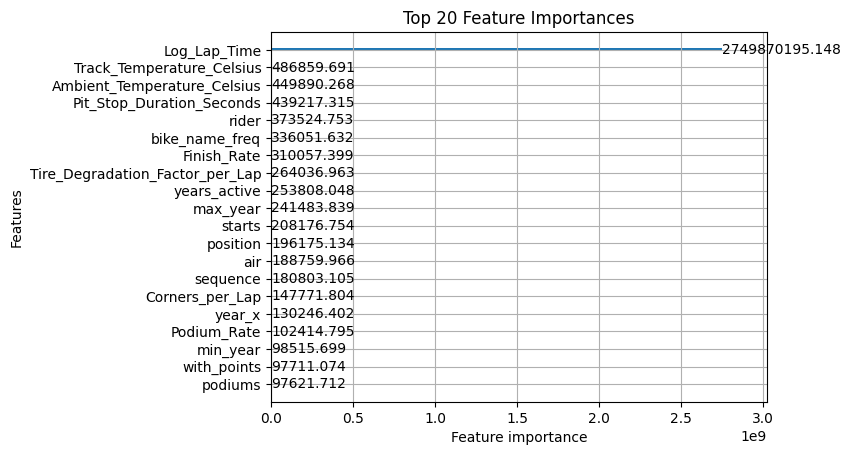

In [76]:
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances")
plt.show()


# After Submission

In [77]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
val = pd.read_csv("val.csv")

In [78]:
train['source'] = 'train'
test['source'] = 'test'
val['source'] = 'val'
full = pd.concat([train, test, val], ignore_index=True)

In [94]:
target_col = "Lap_Time_Seconds"
drop_cols = ["Unique ID", "rider_name", "team_name", "bike_name"]
high_card_cols = ["Rider", "Team", "Bike"]
low_card_categoricals = [
    "category_x", "Tire_Compound_Front", "Tire_Compound_Rear", "Penalty",
    "shortname", "circuit_name", "track", "Track_Condition", "Session", "Weather"
]

In [95]:
for col in high_card_cols:
    freq = full[col].value_counts()
    full[col + "_freq"] = full[col].map(freq)
    full.drop(columns=[col], inplace=True)

KeyError: 'Rider'